# This Code is not used.

In [122]:
import warnings
warnings.filterwarnings("ignore")
# Libraries to read and manipulate data
import pandas as pd
import numpy as np

# libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from statsmodels.api import OLS, add_constant

# Libraries for sampling changing
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

#libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier

#libraries for convenience
from datetime import datetime
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [123]:
# use the same data from the OLS and Linear regression code.
data = pd.read_csv('../Resources/Players_Seasons_Aggregated.csv')
# copying data to preserve original
players_df = data.copy()
players_df = players_df.drop(['Unnamed: 0'],axis= 1)
players_df

,POINTS,GAMES,MIN,ASSISTS,OFFENSIVE_REBOUNDS,PERSONAL_FOULS,PLAYER_ID,Year,TOP_SCORER,2pointer_PROD,3pointer_PROD,FreeThrow_PROD
0,234.000,19,27.053,2.211,0.211,2.053,Allan Houston-275,2004,0,47.235,6.870,4.072
1,2458.000,80,42.225,8.075,0.637,1.900,Allen Iverson-947,2004,0,252.113,6.652,86.848
2,638.000,39,33.949,3.385,2.282,2.538,Andrei Kirilenko-1905,2004,0,56.342,1.164,34.567
3,1517.000,77,38.221,2.130,2.286,2.273,Antawn Jamison-1712,2004,0,134.268,3.592,13.664
4,164.000,24,20.000,3.250,0.375,1.167,Anthony Goldwire-924,2004,0,11.906,3.854,1.399
...,...,...,...,...,...,...,...,...,...,...,...,...
3449,76.000,10,17.200,1.400,0.700,1.200,Vlatko Cancar-1628427,2021,0,13.160,2.000,1.200
3450,872.000,60,29.333,2.733,2.300,2.683,Wendell Carter Jr.-1628976,2021,0,58.737,3.872,7.475
3451,887.000,60,30.983,3.800,0.617,1.600,Will Barton-203115,2021,0,71.425,12.864,2.473
3452,1417.000,57,34.439,4.474,0.298,1.807,Zach LaVine-203897,2021,0,160.380,20.595,22.149


In [124]:
# create the X and y frames of the model.
X = players_df.drop(['Year','PLAYER_ID','POINTS','TOP_SCORER'],axis=1)
y = players_df['TOP_SCORER']

In [125]:
# split the data like a banana.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=15, stratify=y)
print(X_train.shape, X_test.shape)

(2590, 8) (864, 8)


In [126]:
#resampling since each season will only have 1 maximum
ros = RandomOverSampler(random_state=7)
X_train, y_train = ros.fit_resample(X_train, y_train)
Counter(y_train)

Counter({0: 2577, 1: 2577})

In [127]:
# Use Scaler because of the attendance data being all over the place.
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

In [128]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [129]:
# basic untued models used in classes to keep track of names, and the model itself for future exportations
# this is used to dynamicallhy export the models based on best performing.
class decisiontree:
    name = "Decision Tree Classifier"
    model = DecisionTreeClassifier(random_state=1)
class bagging:
    name = "Bagging Classifier"
    model = BaggingClassifier(random_state=1)
class logitreg:
    name = "Logistic Regression Classifier"
    model = LogisticRegression(solver='lbfgs', random_state=1)
class randiforestclass:
    name = "Random Forest Classifier"
    model = RandomForestClassifier(random_state=1)
class adaboost:
    name = "AdaBoost Classifier"
    model = AdaBoostClassifier(random_state=1)
class gradientboost:
    name = "Gradient Boosting Classifier"
    model = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)
class xgboost:
    name = "Extreme Gradient Boosting Classifier"
    model = XGBClassifier(random_state=1,eval_metric='logloss')
class_list = [decisiontree, bagging, logitreg, randiforestclass, adaboost, gradientboost, xgboost]

In [130]:
# Functions on Functions on Functions
def buildmodel(model_class,xtrn,ytrn,xtst):
    # Using the model classes and specifically the model variable this will fit the training and make the prediction using 
    # the x testing set
    model_class.model.fit(xtrn,ytrn)
    model_class.y_predict = model_class.model.predict(xtst)
    print("Model build and fitted :)")
    
def metricsomania(model_class,train,test,train_y,test_y,flag=True):
    # Use the model class, the model variable of said class, and the y predictions
    # defining an empty list to store train and test results
    # Will also create a list of the scores and put the list into the class.
    model = model_class.model
    score_list=[] 
    # Including the Testing set to see how overfitting may be influencing the model.
    pred_train = model.predict(train)
    pred_test = model_class.y_predict
    
    train_acc = model.score(train,train_y)
    test_acc = model.score(test,test_y)
    
    train_recall = metrics.recall_score(train_y,pred_train)
    test_recall = metrics.recall_score(test_y,pred_test)
    
    train_precision = metrics.precision_score(train_y,pred_train)
    test_precision = metrics.precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
    if len(score_list) == 0:
        flag = False
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    # If the flag is not True, god help us
    if flag == True: 
        print("Accuracy on training set : ",model.score(train,train_y))
        print("Accuracy on test set : ",model.score(test,test_y))
        print("Recall on training set : ",metrics.recall_score(train_y,pred_train))
        print("Recall on test set : ",metrics.recall_score(test_y,pred_test))
        print("Precision on training set : ",metrics.precision_score(train_y,pred_train))
        print("Precision on test set : ",metrics.precision_score(test_y,pred_test))
    
    model_class.scores = score_list
    return score_list # returning the list with train and test scores

def make_confusion_matrix(model_class,y_actual,labels=[1, 0]):
    # Make a confusion matrix with a seaborn heatmap and display it.
    model = model_class.model
    cm=metrics.confusion_matrix( y_actual, model_class.y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def Everything_Everywhere_All_At_Once(model_class,xtrn,ytrn,xtst,ytst):
    # Run all of the other functions to reduce the code needed to do it all
    print(f"Model creation, fitting, and assesment of the {model_class.name} model:")
    buildmodel(model_class,xtrn,ytrn,xtst)
    print("-"*50)
    metricsomania(model_class,xtrn,xtst,ytrn,ytst)
    make_confusion_matrix(model_class,ytst)
    print("-"*50)

Model creation, fitting, and assesment of the Decision Tree Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.9918981481481481
Recall on training set :  1.0
Recall on test set :  0.25
Precision on training set :  1.0
Precision on test set :  0.2
--------------------------------------------------


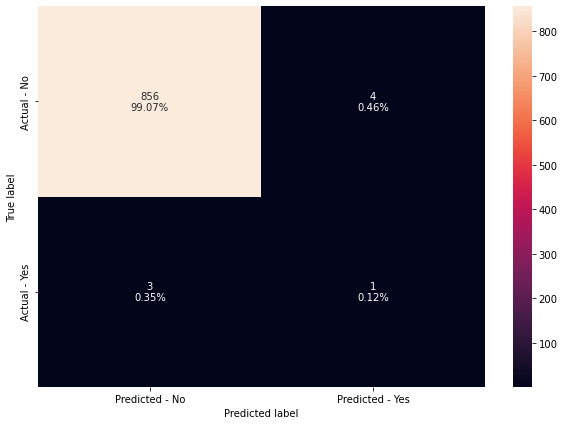

In [131]:
Everything_Everywhere_All_At_Once(decisiontree,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Bagging Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.9942129629629629
Recall on training set :  1.0
Recall on test set :  0.25
Precision on training set :  1.0
Precision on test set :  0.3333333333333333
--------------------------------------------------


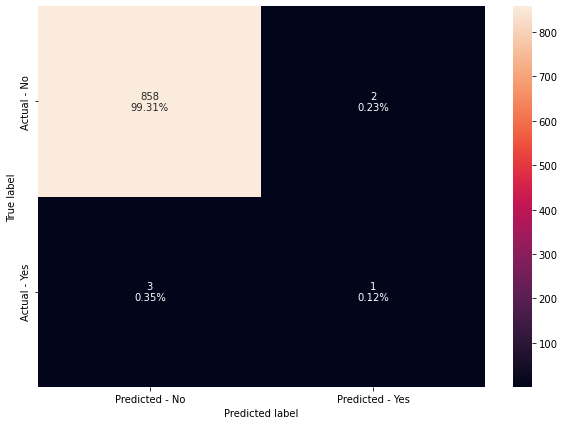

In [132]:
Everything_Everywhere_All_At_Once(bagging,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Logistic Regression Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9871944121071012
Accuracy on test set :  0.9722222222222222
Recall on training set :  1.0
Recall on test set :  1.0
Precision on training set :  0.9750283768444948
Precision on test set :  0.14285714285714285
--------------------------------------------------


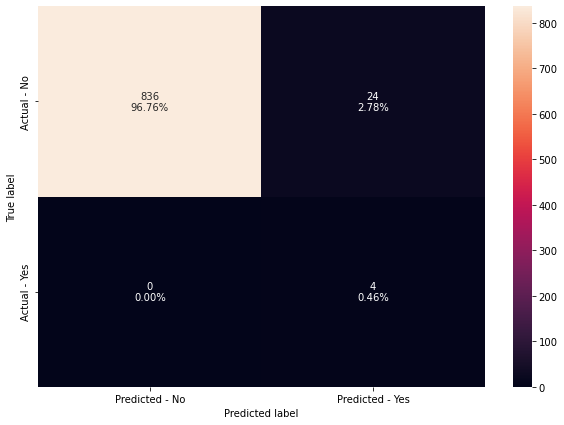

In [133]:
Everything_Everywhere_All_At_Once(logitreg,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Random Forest Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.9953703703703703
Recall on training set :  1.0
Recall on test set :  0.25
Precision on training set :  1.0
Precision on test set :  0.5
--------------------------------------------------


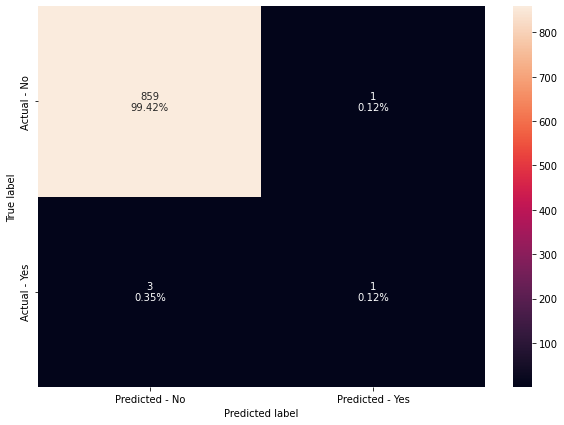

In [134]:
Everything_Everywhere_All_At_Once(randiforestclass,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the AdaBoost Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.9953703703703703
Recall on training set :  1.0
Recall on test set :  0.5
Precision on training set :  1.0
Precision on test set :  0.5
--------------------------------------------------


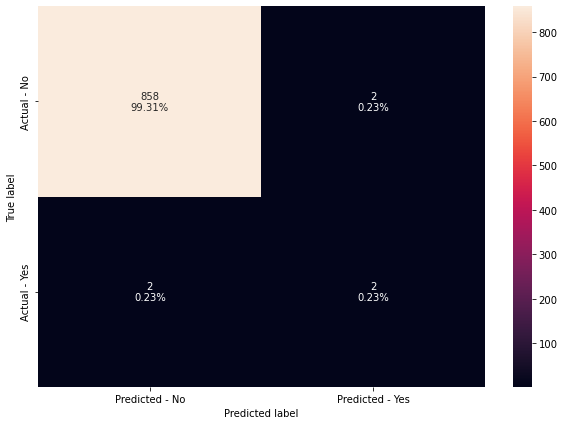

In [135]:
Everything_Everywhere_All_At_Once(adaboost,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.9930555555555556
Recall on training set :  1.0
Recall on test set :  0.5
Precision on training set :  1.0
Precision on test set :  0.3333333333333333
--------------------------------------------------


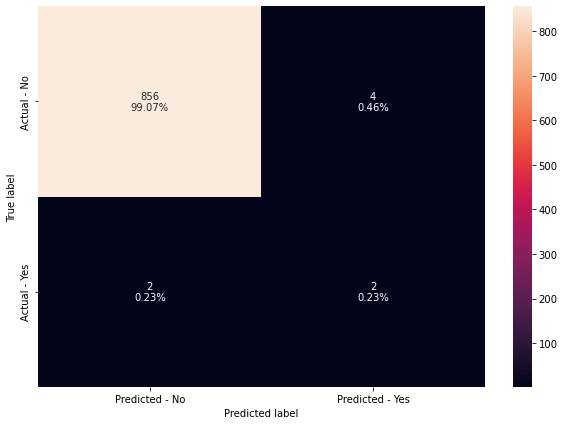

In [136]:
Everything_Everywhere_All_At_Once(gradientboost,X_train_scaled,y_train,X_test_scaled,y_test)

Model creation, fitting, and assesment of the Extreme Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.9942129629629629
Recall on training set :  1.0
Recall on test set :  0.5
Precision on training set :  1.0
Precision on test set :  0.4
--------------------------------------------------


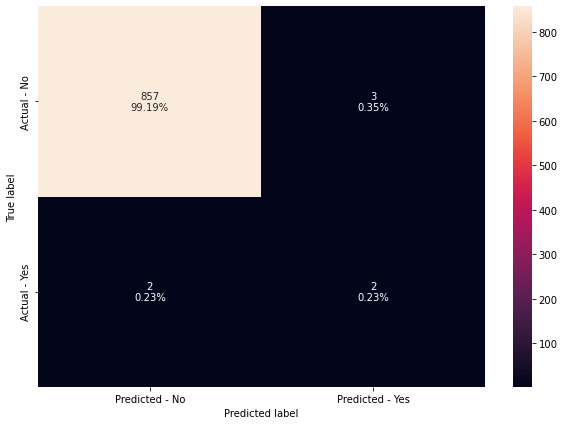

In [137]:
Everything_Everywhere_All_At_Once(xgboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [138]:
# make a dataframe of the different models by using these lists filled with the help of the classes.
model_names = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
for model_class in class_list:
    model_names.append(model_class.name)
    acc_train.append(model_class.scores[0])
    acc_test.append(model_class.scores[1])
    recall_train.append(model_class.scores[2])
    recall_test.append(model_class.scores[3])
    precision_train.append(model_class.scores[4])
    precision_test.append(model_class.scores[5])

In [139]:
# actually build the frame with these sets.
# training metrics are kept to see problems of overfitting.
comparison_frame = pd.DataFrame(
    {
        "Model": model_names,
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
    }
)
#comparison_frame.sort_values(by='Test_Accuracy')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Decision Tree Classifier,1.000,0.992,1.000,0.250,1.000,0.200
1,Bagging Classifier,1.000,0.994,1.000,0.250,1.000,0.333
2,Logistic Regression Classifier,0.987,0.972,1.000,1.000,0.975,0.143
3,Random Forest Classifier,1.000,0.995,1.000,0.250,1.000,0.500
4,AdaBoost Classifier,1.000,0.995,1.000,0.500,1.000,0.500
5,Gradient Boosting Classifier,1.000,0.993,1.000,0.500,1.000,0.333
6,Extreme Gradient Boosting Classifier,1.000,0.994,1.000,0.500,1.000,0.400


In [140]:
# sorting the frame to get top models.
comparison_frame.sort_values(by=['Test_Accuracy'], inplace=True, ascending=False)
comparison_frame.reset_index(inplace=True,drop=True)
# comparison_frame.drop('index')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Random Forest Classifier,1.000,0.995,1.000,0.250,1.000,0.500
1,AdaBoost Classifier,1.000,0.995,1.000,0.500,1.000,0.500
2,Bagging Classifier,1.000,0.994,1.000,0.250,1.000,0.333
3,Extreme Gradient Boosting Classifier,1.000,0.994,1.000,0.500,1.000,0.400
4,Gradient Boosting Classifier,1.000,0.993,1.000,0.500,1.000,0.333
5,Decision Tree Classifier,1.000,0.992,1.000,0.250,1.000,0.200
6,Logistic Regression Classifier,0.987,0.972,1.000,1.000,0.975,0.143


### Hyperparameter Tuning
#### To my teammates:
Gridsearch is a tool used to bruteforce search a matrix of hyperparameters for a model. The model will be optimized to the training set so overfitting is a risk. However, in my experience a tuned model is very powerful so we'll see how effective this is.
#### To anyone else whom it may concern:
Using gridsearch to tune the hyperparameters was used to be used to create a stonger model
They are commented out so running the code again wont take a long time.

In [141]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV

# param_grid = {'decisiontreeclassifier__max_depth': np.arange(2,30), 
#               'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 7, 10],
#               'decisiontreeclassifier__max_leaf_nodes' : [2, 3, 5, 10,15],
#               'decisiontreeclassifier__min_impurity_decrease': [0.0001,0.001,0.01,0.1]
#              }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Decision Tree Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9978657353511835
Accuracy on test set :  0.9953703703703703
Recall on training set :  1.0
Recall on test set :  0.75
Precision on training set :  0.9957496136012365
Precision on test set :  0.5
--------------------------------------------------


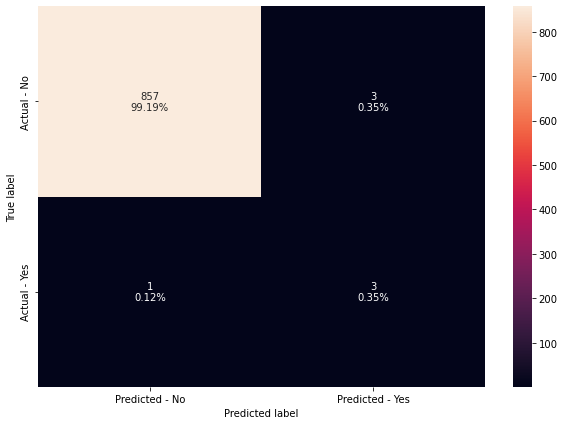

In [142]:
# build a class for the tuned model.
class tuned_decision_tree:
    name = "Tuned Decision Tree Classifier"
tuned_decision_tree.model = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(
        max_depth=9,
        max_leaf_nodes=15,
        random_state=1,
        min_impurity_decrease=0.0001,
        min_samples_leaf=5
    ),
)
# adding the class to the list of classes
class_list.append(tuned_decision_tree)
Everything_Everywhere_All_At_Once(tuned_decision_tree,X_train_scaled,y_train,X_test_scaled,y_test)

In [143]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), BaggingClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV

# param_grid = {
#               'baggingclassifier__max_samples': [0.7,0.8,0.9,1], 
#               'baggingclassifier__max_features': [0.7,0.8,0.9,1],
#               'baggingclassifier__n_estimators' : [10,20,30,40,50],
#              }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Bagging Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.9953703703703703
Recall on training set :  1.0
Recall on test set :  0.0
Precision on training set :  1.0
Precision on test set :  0.0
--------------------------------------------------


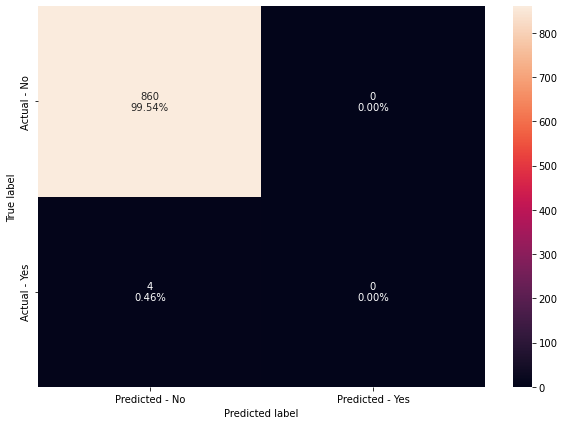

In [144]:
class tuned_bagging:
    name = "Tuned Bagging Classifier"
tuned_bagging.model = make_pipeline(
    StandardScaler(),
    BaggingClassifier(
        max_features=1,
        max_samples=0.7,
        random_state=1,
        n_estimators=10,
    ),
)
class_list.append(tuned_bagging)
Everything_Everywhere_All_At_Once(tuned_bagging,X_train_scaled,y_train,X_test_scaled,y_test)

In [145]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV

# param_grid = {
#     "randomforestclassifier__n_estimators": [100,150,250],
#     "randomforestclassifier__min_samples_leaf": np.arange(1, 6),
#     "randomforestclassifier__max_features": [np.arange(0.3, 0.6, 0.1),'sqrt','log2'],
#     "randomforestclassifier__max_samples": np.arange(0.2, 0.6, 0.1),
# }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Random Forest Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9996119518820333
Accuracy on test set :  0.9930555555555556
Recall on training set :  1.0
Recall on test set :  0.25
Precision on training set :  0.9992245056223342
Precision on test set :  0.25
--------------------------------------------------


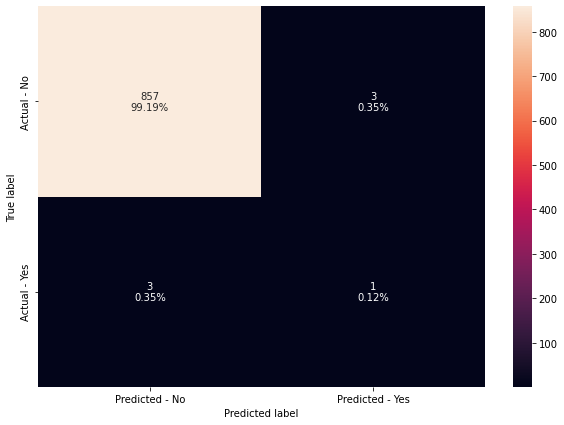

In [146]:
class tuned_randiforestclass:
    name = "Tuned Random Forest Classifier"
tuned_randiforestclass.model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=100,
        max_features='sqrt',
        random_state=1,
        max_samples=0.5,
        min_samples_leaf=1
    ),
)
class_list.append(tuned_randiforestclass)
Everything_Everywhere_All_At_Once(tuned_randiforestclass,X_train_scaled,y_train,X_test_scaled,y_test)

In [147]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), AdaBoostClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV
# param_grid = {
#     "adaboostclassifier__n_estimators": np.arange(10, 110, 10),
#     "adaboostclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
#     "adaboostclassifier__base_estimator": [
#         DecisionTreeClassifier(max_depth=1, random_state=1),
#         DecisionTreeClassifier(max_depth=2, random_state=1),
#         DecisionTreeClassifier(max_depth=3, random_state=1),
#     ],
# }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned AdaBoost Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.9965277777777778
Recall on training set :  1.0
Recall on test set :  0.75
Precision on training set :  1.0
Precision on test set :  0.6
--------------------------------------------------


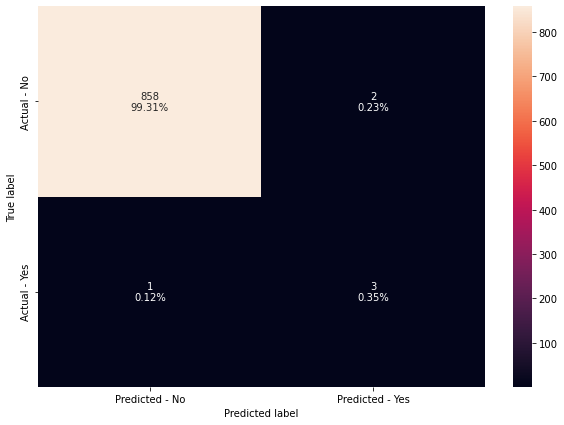

In [148]:
class tuned_adaboost:
    name = "Tuned AdaBoost Classifier"
tuned_adaboost.model = make_pipeline(
    StandardScaler(),
    AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
        n_estimators=30,
        learning_rate=1,
        random_state=1,
    ),
)
class_list.append(tuned_adaboost)
Everything_Everywhere_All_At_Once(tuned_adaboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [149]:
# # Creating pipeline
# pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=1))

# # Parameter grid to pass in GridSearchCV
# param_grid = {
#     "gradientboostingclassifier__init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
#     "gradientboostingclassifier__n_estimators": np.arange(75,150,25),
#     "gradientboostingclassifier__learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
#     "gradientboostingclassifier__subsample":[0.5,0.7,1],
#     "gradientboostingclassifier__max_features":[0.5,0.7,1],
# }

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  1.0
Accuracy on test set :  0.9953703703703703
Recall on training set :  1.0
Recall on test set :  0.5
Precision on training set :  1.0
Precision on test set :  0.5
--------------------------------------------------


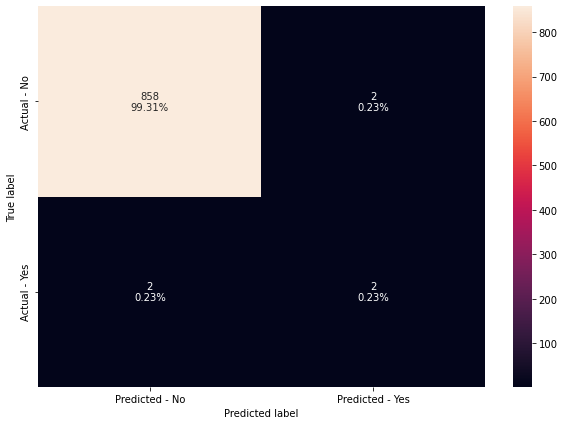

In [150]:
class tuned_gradientboost:
    name = "Tuned Gradient Boosting Classifier"
tuned_gradientboost.model = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(
        init=AdaBoostClassifier(random_state=1),
        learning_rate=1,
        max_features=.5,
        n_estimators=125,
        subsample=1,
        random_state=1,
    ),
)
class_list.append(tuned_gradientboost)
Everything_Everywhere_All_At_Once(tuned_gradientboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [151]:
# #Creating pipeline
# pipe=make_pipeline(StandardScaler(), XGBClassifier(random_state=1,eval_metric='logloss'))

# #Parameter grid to pass in GridSearchCV
# param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
#             'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05], 'xgbclassifier__gamma':[0,1,3,5],
#             'xgbclassifier__subsample':[0.7,0.8,0.9,1]}

# # Type of scoring used to compare parameter combinations
# scorer = metrics.make_scorer(metrics.accuracy_score)

# # Calling GridSearchCV
# grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs = -1)

# # Fitting parameters in GridSeachCV
# grid_cv.fit(X_train_scaled, y_train)

# print(
#     "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
# )

Model creation, fitting, and assesment of the Tuned Extreme Gradient Boosting Classifier model:
Model build and fitted :)
--------------------------------------------------
Accuracy on training set :  0.9998059759410167
Accuracy on test set :  0.9942129629629629
Recall on training set :  1.0
Recall on test set :  0.5
Precision on training set :  0.9996121024049651
Precision on test set :  0.4
--------------------------------------------------


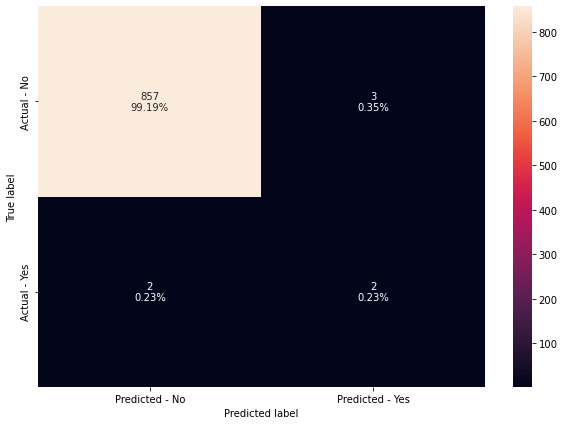

In [152]:
class tuned_xgboost:
    name = "Tuned Extreme Gradient Boosting Classifier"
tuned_xgboost.model = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=1,
        n_estimators=100,
        scale_pos_weight=2,
        subsample=0.8,
        learning_rate=0.2,
        gamma=0,
        eval_metric='logloss',
    ),
)
class_list.append(tuned_xgboost)
Everything_Everywhere_All_At_Once(tuned_xgboost,X_train_scaled,y_train,X_test_scaled,y_test)

In [153]:
# Once again creating a comparison frame, this time adding the tuned models.
model_names = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
for model_class in class_list:
    model_names.append(model_class.name)
    acc_train.append(model_class.scores[0])
    acc_test.append(model_class.scores[1])
    recall_train.append(model_class.scores[2])
    recall_test.append(model_class.scores[3])
    precision_train.append(model_class.scores[4])
    precision_test.append(model_class.scores[5])

In [154]:
# Make the frame with these lists.
comparison_frame = pd.DataFrame(
    {
        "Model": model_names,
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
    }
)
comparison_frame.sort_values(by='Test_Accuracy')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Decision Tree Classifier,1.000,0.992,1.000,0.250,1.000,0.200
1,Bagging Classifier,1.000,0.994,1.000,0.250,1.000,0.333
2,Logistic Regression Classifier,0.987,0.972,1.000,1.000,0.975,0.143
3,Random Forest Classifier,1.000,0.995,1.000,0.250,1.000,0.500
4,AdaBoost Classifier,1.000,0.995,1.000,0.500,1.000,0.500
5,Gradient Boosting Classifier,1.000,0.993,1.000,0.500,1.000,0.333
6,Extreme Gradient Boosting Classifier,1.000,0.994,1.000,0.500,1.000,0.400
7,Tuned Decision Tree Classifier,0.998,0.995,1.000,0.750,0.996,0.500
8,Tuned Bagging Classifier,1.000,0.995,1.000,0.000,1.000,0.000
9,Tuned Random Forest Classifier,1.000,0.993,1.000,0.250,0.999,0.250


In [155]:
comparison_frame.sort_values(by=['Test_Accuracy'], inplace=True, ascending=False)
comparison_frame.reset_index(inplace=True,drop=True)
#comparison_frame.drop('index')
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,Tuned AdaBoost Classifier,1.000,0.997,1.000,0.750,1.000,0.600
1,Random Forest Classifier,1.000,0.995,1.000,0.250,1.000,0.500
2,AdaBoost Classifier,1.000,0.995,1.000,0.500,1.000,0.500
3,Tuned Decision Tree Classifier,0.998,0.995,1.000,0.750,0.996,0.500
4,Tuned Bagging Classifier,1.000,0.995,1.000,0.000,1.000,0.000
5,Tuned Gradient Boosting Classifier,1.000,0.995,1.000,0.500,1.000,0.500
6,Bagging Classifier,1.000,0.994,1.000,0.250,1.000,0.333
7,Extreme Gradient Boosting Classifier,1.000,0.994,1.000,0.500,1.000,0.400
8,Tuned Extreme Gradient Boosting Classifier,1.000,0.994,1.000,0.500,1.000,0.400
9,Gradient Boosting Classifier,1.000,0.993,1.000,0.500,1.000,0.333


In [156]:
top_name = comparison_frame['Model'][0]
second_best = comparison_frame['Model'][1]
third_best = comparison_frame['Model'][2]
print(f"Best model is the {top_name} model\n"
     f"Second best model is the {second_best} model\n"
     f"Third best model is the {third_best} model")

Best model is the Tuned AdaBoost Classifier model
Second best model is the Random Forest Classifier model
Third best model is the AdaBoost Classifier model


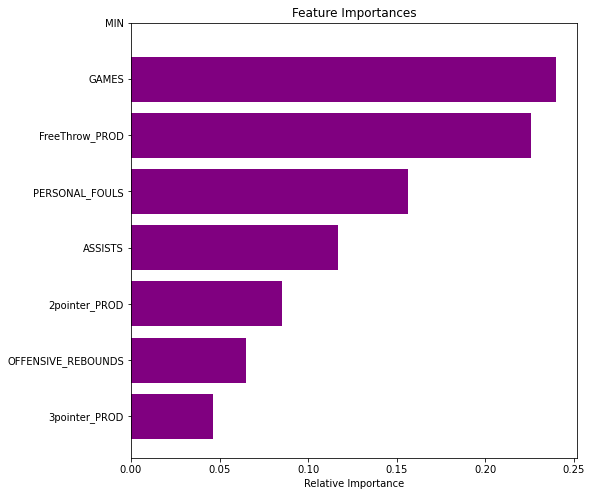

In [161]:
#example of feature importance.
feature_names = X_train.columns
importances = tuned_adaboost.model[1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="purple", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [158]:
top_name = comparison_frame['Model'][0]
second_best = comparison_frame['Model'][1]
third_best = comparison_frame['Model'][2]
print(f"Best model is the {top_name} model\n"
     f"Second best model is the {second_best} model\n"
     f"Third best model is the {third_best} model")


Best model is the Tuned AdaBoost Classifier model
Second best model is the Random Forest Classifier model
Third best model is the AdaBoost Classifier model


In [159]:
# export the model
import pickle
for model_class in class_list:
    if model_class.name == top_name:
        filename = f'../Models/Top_Scorer_{top_name}.sav'
        pickle.dump(model_class.model, open(filename, 'wb'))
    elif model_class.name == second_best:
        filename = f'../Models/Second_Top_Scorer_{second_best}.sav'
        pickle.dump(model_class.model, open(filename, 'wb'))
    elif model_class.name == third_best:
        filename = f'../Models/Third_Top_Scorer_{third_best}.sav'
        pickle.dump(model_class.model, open(filename, 'wb'))

In [160]:
#left over because idk